In [1]:
!pip install -U transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 92.7 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 68.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 96.8 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.12.0
    Uninstalling huggingface-hub-0.12.0:
      Successfully uninstalled huggingface-hub-0.12.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.21.3
    Uninstalling transformers-4.21.3:
      Successfully uninstalled transformers-4.21.3


In [2]:
!pip install datasets
!pip install soundfile
!pip install librosa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 36.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 kB 73.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 98.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 94.0 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 36.2 MB/s eta 0:00:0000:0100:01
  Created wheel for audioread: filename=audioread-3.0.0-py3-none-any.whl size=23702 sha256=aec20998fbd9857eb9ea21cc035eab9491e37260bd53027e41753d712b3ed439
  Stored in directory: /root/.cache/pip/wheels/7a/6a/b0/92760a6d6bc2bff5464970af910c0b0b921390993f3199cdf7
Successfully built audioread


In [3]:
# !pip install git+https://github.com/huggingface/transformers

In [4]:
!pip install speechbrain accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.0/519.0 kB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 45.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.6/109.6 kB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.4/519.4 kB 68.8 MB/s eta 0:00:00


In [5]:
!apt-get install git-lfs
!git lfs install

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  git-lfs
0 upgraded, 1 newly installed, 0 to remove and 3 not upgraded.
Need to get 3316 kB of archives.
After this operation, 11.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 git-lfs amd64 2.9.2-1 [3316 kB]
Fetched 3316 kB in 0s (25.1 MB/s)
Selecting previously unselected package git-lfs.
(Reading database ... 69943 files and directories currently installed.)
Preparing to unpack .../git-lfs_2.9.2-1_amd64.deb ...
Unpacking git-lfs (2.9.2-1) ...
Setting up git-lfs (2.9.2-1) ...
Processing triggers for man-db (2.9.1-1) ...
Updated git hooks.
Git LFS initialized.


In [6]:
!pip install wandb --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 68.3 MB/s eta 0:00:00
  Attempting uninstall: wandb
    Found existing installation: wandb 0.13.4
    Uninstalling wandb-0.13.4:
      Successfully uninstalled wandb-0.13.4


## Fine-tuning SpeechT5


### Housekeeping

In [7]:
from huggingface_hub import notebook_login

notebook_login()

### The dataset

In [8]:
from datasets import load_dataset, Audio

dataset = load_dataset("facebook/voxpopuli", "es", split="train+validation")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset voxpopuli downloaded and prepared to /root/.cache/huggingface/datasets/facebook___voxpopuli/es/1.3.0/b5ff837284f0778eefe0f642734e142d8c3f574eba8c9c8a4b13602297f73604. Subsequent calls will reuse this data.


In [9]:
len(dataset)

52553

In [10]:
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))

### Preprocessing the data

In [11]:
from transformers import SpeechT5Processor
checkpoint = "microsoft/speecht5_tts"
processor = SpeechT5Processor.from_pretrained(checkpoint)

#### Text cleanup for SpeechT5 tokenization

In [12]:
tokenizer = processor.tokenizer

In [13]:
dataset[0]

{'audio_id': '20200914-0900-PLENARY-es_20200914-17:23:57_4',
 'language': 3,
 'audio': {'path': '/root/.cache/huggingface/datasets/downloads/extracted/2fb3261dbf9ef7ba9a3acf70075ebdad88b9ffa07a75f71f1ba5635e36443a6d/train_part_0/20200914-0900-PLENARY-es_20200914-17:23:57_4.wav',
  'array': array([ 0.00064087,  0.00039673, -0.00048828, ...,  0.00619507,
         -0.00012207, -0.00494385], dtype=float32),
  'sampling_rate': 16000},
 'raw_text': 'Y, desde luego, esa razón no puede tener que ver con la explicación surrealista que hemos escuchado más de una vez de que se trata de una conspiración izquierdista.',
 'normalized_text': 'y desde luego esa razón no puede tener que ver con la explicación surrealista que hemos escuchado más de una vez de que se trata de una conspiración izquierdista.',
 'gender': 'male',
 'speaker_id': '96812',
 'is_gold_transcript': True,
 'accent': 'None'}

In [14]:
def extract_all_chars(batch):
    all_text = " ".join(batch["normalized_text"])
    vocab = list(set(all_text))
    return {"vocab":[vocab], "all_text": [all_text]}

In [15]:
vocabs = dataset.map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=dataset.column_names)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [16]:
dataset_vocab = set(vocabs["vocab"][0])
tokenizer_vocab = {k for k, _ in tokenizer.get_vocab().items()}

In [17]:
tokenizer_vocab

{'!',
 '"',
 "'",
 '(',
 ')',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '</s>',
 '<ctc_blank>',
 '<mask>',
 '<pad>',
 '<s>',
 '<unk>',
 '?',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 '[',
 ']',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '{',
 '}',
 'æ',
 'é',
 'ê',
 'œ',
 '̄',
 '—',
 '▁'}

In [18]:
# identify all special characters that tokenizer does not contain
dataset_vocab - tokenizer_vocab

{' ', '1', 'á', 'í', 'ñ', 'ó', 'ú', 'ü'}

In [19]:
replacements= [
    ('á', 'a'),
    ('í', 'i'),
    ('ñ', 'n'),
    ('ó', 'o'),
    ('ú', 'u'),
    ('ü', 'u'), 
    
]

In [20]:
# replace special characters
def cleanup_text(inputs):
    for src, dst in replacements:
        inputs["normalized_text"] = inputs["normalized_text"].replace(src, dst)
    return inputs

dataset = dataset.map(cleanup_text)
    

  0%|          | 0/52553 [00:00<?, ?ex/s]

In [21]:
len(dataset)

52553

#### Speakers

In [22]:
from collections import defaultdict
speaker_counts = defaultdict(int)
for speaker_id in dataset["speaker_id"]:
    speaker_counts[speaker_id] += 1
    

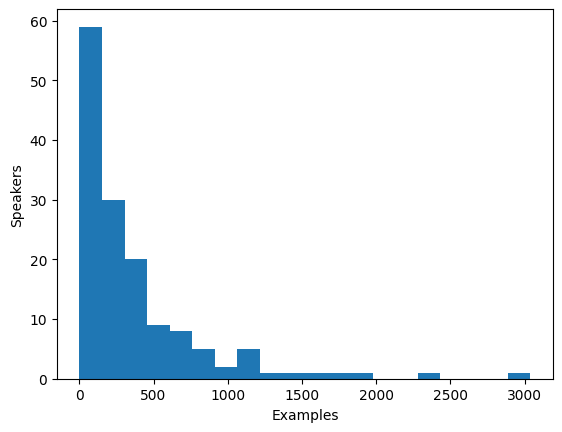

In [23]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(speaker_counts.values(), bins=20)
plt.ylabel("Speakers")
plt.xlabel("Examples")
plt.show()

In [24]:
# balance dataset by limiting speakers to middle
def select_speaker(speaker_id):
    return 50 <= speaker_counts[speaker_id] <= 700
dataset = dataset.filter(select_speaker, input_columns=["speaker_id"])

  0%|          | 0/53 [00:00<?, ?ba/s]

In [25]:
len(set(dataset["speaker_id"]))

104

In [26]:
len(dataset)

25823

#### Speaker embeddings

In [27]:
# needed to differentiate between multiple speakers
import os
import torch
from speechbrain.pretrained import EncoderClassifier

spk_model_name = "speechbrain/spkrec-xvect-voxceleb"
device = "cuda"
speaker_model = EncoderClassifier.from_hparams(source=spk_model_name, run_opts={"device":device}, savedir=os.path.join("/tmp", spk_model_name))

In [28]:
def create_speaker_embedding(waveform):
    with torch.no_grad():
        speaker_embeddings = speaker_model.encode_batch(torch.tensor(waveform))
        speaker_embeddings = torch.nn.functional.normalize(speaker_embeddings, dim=2)
        speaker_embeddings = speaker_embeddings.squeeze().cpu().numpy()
    return speaker_embeddings

#### Processing the dataset

In [29]:
def prepare_dataset(example):
    audio = example["audio"]
    example = processor(text=example["normalized_text"], audio_target=audio["array"], sampling_rate=audio["sampling_rate"], return_attention_mask=False)
    # strip off batch dimension
    example["labels"] = example["labels"][0]
    
    #use SpeechBrain to get x-vector
    example["speaker_embeddings"] = create_speaker_embedding(audio["array"])
    return example

In [30]:
# test with one example
processed_example = prepare_dataset(dataset[0])
list(processed_example.keys())

['input_ids', 'labels', 'speaker_embeddings']

In [31]:
# check embeddings shape
processed_example["speaker_embeddings"].shape

(512,)

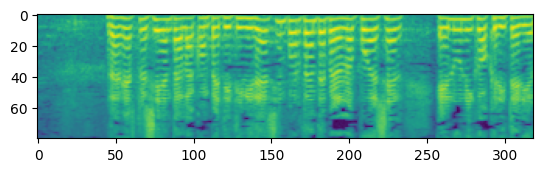

In [32]:
# check labels is log-mel spectrogram with 80 bins
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(processed_example["labels"].T)
plt.show()

In [33]:
len(dataset)

25823

In [34]:
dataset = dataset.map(prepare_dataset, remove_columns=dataset.column_names, num_proc=1)
dataset

  0%|          | 0/25823 [00:00<?, ?ex/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (667 > 600). Running this sequence through the model will result in indexing errors


Dataset({
    features: ['input_ids', 'labels', 'speaker_embeddings'],
    num_rows: 25823
})

In [35]:
dataset.column_names

['input_ids', 'labels', 'speaker_embeddings']

In [36]:
from collections import defaultdict
lengths = defaultdict(int)
for input_id in dataset["input_ids"]:
    lengths[len(input_id)] += 1

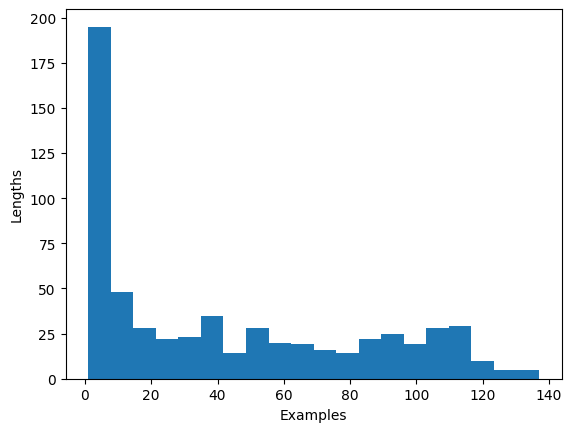

In [37]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(lengths.values(), bins=20)
plt.ylabel("Lengths")
plt.xlabel("Examples")
plt.show()

In [38]:
len(dataset)

25823

In [39]:
def is_not_too_long(input_ids):
    input_length = len(input_ids)
    return input_length < 400
dataset = dataset.filter(is_not_too_long, input_columns=["input_ids"])
len(dataset)

  0%|          | 0/26 [00:00<?, ?ba/s]

25060

In [40]:
len(dataset)

25060

In [41]:
dataset = dataset.train_test_split(test_size=0.1)

#### Data collator

In [42]:
# to combine multiple examples into a batch, you need to define a custom data collator. 
from dataclasses import dataclass
from typing import Any, Dict, List, Union


@dataclass
class TTSDataCollatorWithPadding:
    processor: Any

    def __call__(
        self, features: List[Dict[str, Union[List[int], torch.Tensor]]]
    ) -> Dict[str, torch.Tensor]:
        input_ids = [{"input_ids": feature["input_ids"]} for feature in features]
        label_features = [{"input_values": feature["labels"]} for feature in features]
        speaker_features = [feature["speaker_embeddings"] for feature in features]

        # collate the inputs and targets into a batch
        batch = processor.pad(
            input_ids=input_ids, labels=label_features, return_tensors="pt"
        )

        # replace padding with -100 to ignore loss correctly
        batch["labels"] = batch["labels"].masked_fill(
            batch.decoder_attention_mask.unsqueeze(-1).ne(1), -100
        )

        # not used during fine-tuning
        del batch["decoder_attention_mask"]

        # round down target lengths to multiple of reduction factor
        if model.config.reduction_factor > 1:
            target_lengths = torch.tensor(
                [len(feature["input_values"]) for feature in label_features]
            )
            target_lengths = target_lengths.new(
                [
                    length - length % model.config.reduction_factor
                    for length in target_lengths
                ]
            )
            max_length = max(target_lengths)
            batch["labels"] = batch["labels"][:, :max_length]

        # also add in the speaker embeddings
        batch["speaker_embeddings"] = torch.tensor(speaker_features)

        return batch

In [43]:
data_collator = TTSDataCollatorWithPadding(processor=processor)

### Train the model

In [44]:
from transformers import SpeechT5ForTextToSpeech
model = SpeechT5ForTextToSpeech.from_pretrained(checkpoint)

In [45]:
from functools import partial

# disable cache during training since it's incompatible with gradient checkpointing
model.config.use_cache = False

# set language and task for generation and re-enable cache
model.generate = partial(model.generate, use_cache=True)

In [46]:
import wandb
wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [47]:
wandb.init(project="huggingface-audio-course-unit6-handson", resume=True)

wandb: Currently logged in as: ptah23. Use `wandb login --relogin` to force relogin


In [48]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="speecht5_finetuned_voxpopuli_es",  # change to a repo name of your choice
    per_device_train_batch_size=4,
    gradient_accumulation_steps=8,
    learning_rate=1e-5,
    warmup_steps=500,
    max_steps=4000,
    gradient_checkpointing=True,
    fp16=True,
    evaluation_strategy="steps",
    per_device_eval_batch_size=4,
    save_steps=100,
    eval_steps=100,
    logging_steps=25,
    report_to=["wandb"],
    load_best_model_at_end=True,
    greater_is_better=False,
    label_names=["labels"],
    push_to_hub=True,
)

In [49]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    data_collator=data_collator,
    tokenizer=processor,
)

/notebooks/speecht5_finetuned_voxpopuli_es is already a clone of https://huggingface.co/ptah23/speecht5_finetuned_voxpopuli_es. Make sure you pull the latest changes with `repo.git_pull()`.


In [50]:
#trainer.train()
trainer.train(resume_from_checkpoint=True)

You are resuming training from a checkpoint trained with 4.31.0.dev0 of Transformers but your current version is 4.30.2. This is not recommended and could yield to errors or unwanted behaviors.
There were missing keys in the checkpoint model loaded: ['speecht5.encoder.prenet.encode_positions.pe', 'speecht5.decoder.prenet.encode_positions.pe'].
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
2500,0.479900,0.442862
2600,0.480600,0.442916
2700,0.477700,0.441647
2800,0.478700,0.442325
2900,0.482300,0.441941
3000,0.482200,0.440869
3100,0.479600,0.440414
3200,0.480500,0.441790
3300,0.479500,0.440929
3400,0.478400,0.441062


TrainOutput(global_step=4000, training_loss=0.19185583806037904, metrics={'train_runtime': 5110.521, 'train_samples_per_second': 25.046, 'train_steps_per_second': 0.783, 'total_flos': 2.9313899856717696e+16, 'train_loss': 0.19185583806037904, 'epoch': 5.68})

In [51]:
kwargs = {
    "dataset_tags": "facebook/voxpopuli",
    "dataset": "Vox Populi ES",  # a 'pretty' name for the training dataset
    "language": "es",
    "model_name": "speec T5 ES - Peter Gelderbloem",  # a 'pretty' name for your model
    "finetuned_from": "microsoft/speecht5_tts",
    "tasks": "text-to-speech",
}
trainer.push_to_hub(**kwargs)

Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 1.00/558M [00:00<?, ?B/s]

To https://huggingface.co/ptah23/speecht5_finetuned_voxpopuli_es
   6556257..d156f1e  main -> main

To https://huggingface.co/ptah23/speecht5_finetuned_voxpopuli_es
   d156f1e..b5748f6  main -> main



'https://huggingface.co/ptah23/speecht5_finetuned_voxpopuli_es/commit/d156f1e0e5f41a5f99d894bdf12d54e95967594e'

### Inference

In [52]:
model = SpeechT5ForTextToSpeech.from_pretrained("ptah23/speecht5_finetuned_voxpopuli_es")

In [55]:
example = dataset["test"][122]
speaker_embeddings = torch.tensor(example["speaker_embeddings"]).unsqueeze(0)

In [56]:
text = "me gustas tu"
inputs = processor(text=text, return_tensors="pt")

In [57]:
# instantiate vocoder and generate
from transformers import SpeechT5HifiGan
vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")
speech = model.generate_speech(inputs["input_ids"], speaker_embeddings, vocoder=vocoder)

In [58]:
import IPython
IPython.display.Audio(speech.numpy(), rate=16000)